# Tracking objects in 3D space
---

Here we are going to look at calculating the linkage probability between a new object observation and the existing measurements.

Using BayesianTracker from https://github.com/quantumjot

---

Kalman filter:

Excellent introduction to Kalman filters:
http://www.cs.unc.edu/~welch/media/pdf/kalman_intro.pdf

Prediction:

\begin{equation}
\begin{aligned}
\hat{x}_t &= A\hat{x}_{t-1} \\
P_t &= AP_{t-1}A^T+Q
\end{aligned}
\end{equation}


The process covariance can be estimated like this:

\begin{equation}
Q = G \cdot G^T \cdot \sigma_v^2
\end{equation}

Update:

\begin{equation}
\begin{aligned}
K_t &= P_tH^T(HP_tH^T+R)^{-1} \\
\hat{x}_t &= \hat{x}_t + K_t(z_k-H\hat{x}_t) \\
P_k &= (I-K_tH)P_t
\end{aligned}
\end{equation}



In [1]:
%matplotlib inline

# temporarily added BayesianTracker to the path
import sys
sys.path.append('../btrack/')



# math
import numpy as np
import scipy.stats as stats
import scipy.integrate as integrate

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# btrack components
import core
import utils
from agents import Agent
from render import plot_tracks


/Users/arl/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO][2018/07/25 10:56:30 AM] btrack (v0.2.6) library imported
[INFO][2018/07/25 10:56:30 AM] Loaded btrack: /Users/arl/Dropbox/Code/BayesianTracker/btrack/libs/libtracker.dylib


In [2]:
# instantiate agents
n_agents = 250
n_frames = 300
n_chaff = 5000

agents = [Agent(noise=0.1, periodic_boundary=True) for i in xrange(n_agents)]

# iterate over some steps
for agent in agents:
    for iteration in range(n_frames):
        agent.update()




In [3]:
def chaff(n_frames):
    """ Random observation """
    position = np.random.randint(0,high=1000, size=(3,))
    obj = core.PyTrackObject()
    obj.ID = int(1e5)
    obj.x = position[0]
    obj.y = position[1]
    obj.z = position[2]
    obj.t = np.random.randint(0,high=n_frames)
    obj.dummy = False
    obj.label = 0
    obj.probability = np.zeros((5,),dtype='float')
    return obj

### Start a BayesianTracker session

In [4]:
data = []
# loop over all frames and all agents, add the data to the tracker
for agent in agents:
    for t in xrange(len(agent)):
        data.append( agent[t] )

# add some random chaff too 
data = data + [chaff(n_frames) for i in xrange(n_chaff)]


In [5]:
data = utils.crop_volume(data, ((0,1600), (0,1600), (0,1600), (0,500)))

In [6]:
# start a session
with core.BayesianTracker() as trk:

    trk.append(data)

    trk.configure_from_file('particle_config.json')
    trk.return_kalman = True

    trk.track_interactive(step_size=100)
    
    # get the tracks
    tracks = trk.tracks

    
    # get the imaging volume (xyzt)
    volume = trk.volume

    # generate some hypotheses and optimise
    hypotheses = trk.hypotheses()
    trk.optimise()
    
    # get the optimized tracks
    tracks2 = trk.tracks



[INFO][2018/07/25 10:56:33 AM] Starting BayesianTracker session
[INFO][2018/07/25 10:56:33 AM] Loading motion model: MDCK_motion
[INFO][2018/07/25 10:56:33 AM] Loading hypothesis model: MDCK_hypothesis
[INFO][2018/07/25 10:56:33 AM] Starting tracking... 
[INFO][2018/07/25 10:56:33 AM] Tracking objects in frames 0 to 99 (of 301)...
[INFO][2018/07/25 10:56:37 AM]  - Timing (Bayesian updates: 30.60ms, Linking: 1.87ms)
[INFO][2018/07/25 10:56:37 AM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2018/07/25 10:56:37 AM]  - Stats (Active: 336, Lost: 10853, Conflicts resolved: 122)
[INFO][2018/07/25 10:56:37 AM] Tracking objects in frames 100 to 199 (of 301)...
[INFO][2018/07/25 10:56:40 AM]  - Timing (Bayesian updates: 27.92ms, Linking: 1.94ms)
[INFO][2018/07/25 10:56:40 AM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2018/07/25 10:56:40 AM]  - Stats (Active: 316, Lost: 21882, Conflicts resolved: 247)
[INFO][2018/07/25 10:56:40 AM] Tracking objects in frames 200 to 299 (of

In [7]:
print volume


[(0.0, 999.9722444755683), (0.0, 999.9985258060409), (0.0, 999.9735671333922), [0, 300L]]


### Plot the trajectories and the original data
---

Plot the output of the tracking...

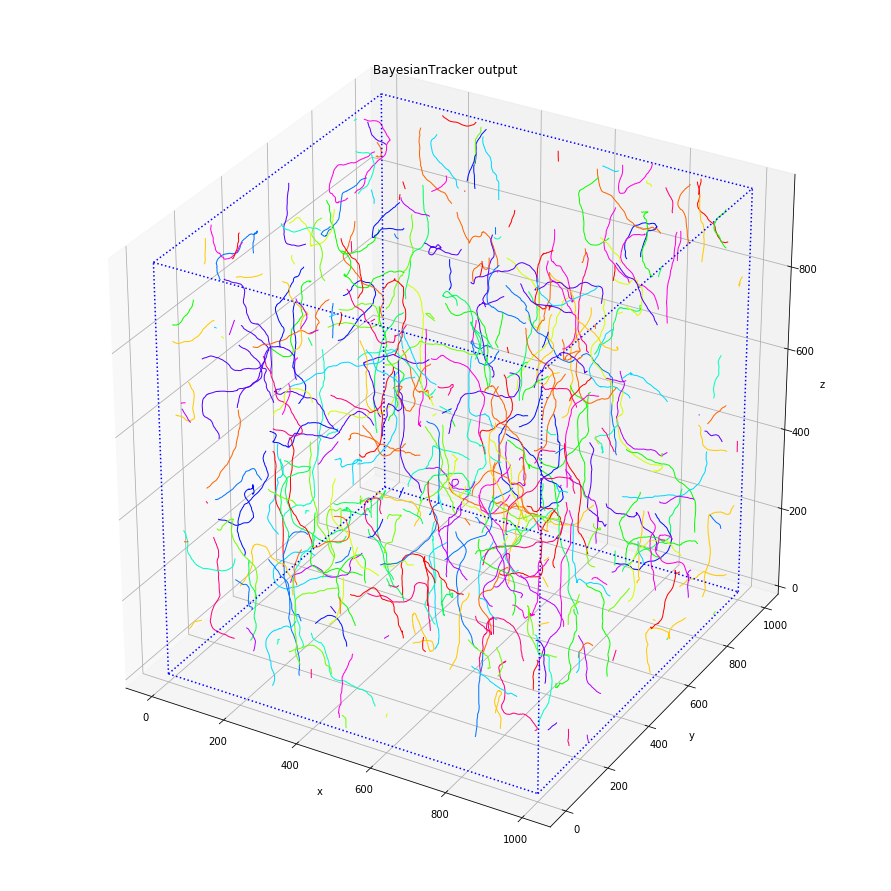

In [8]:
plot_tracks(tracks, order='xyz', box=volume, cmap=plt.get_cmap('hsv'), labels=False)

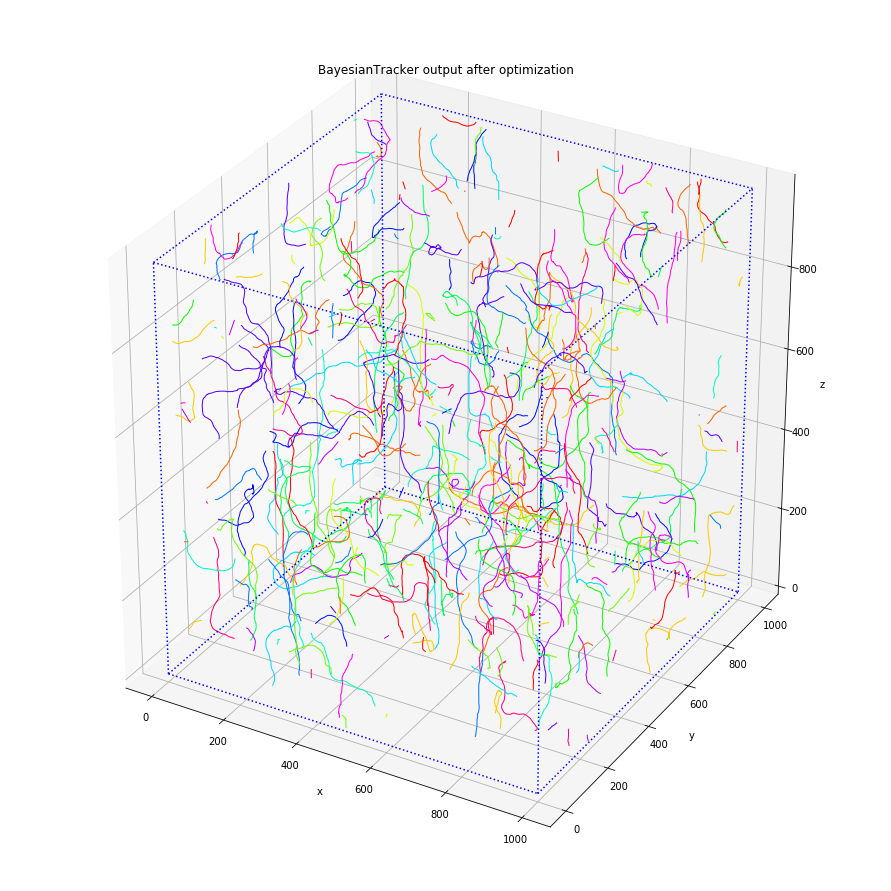

In [9]:
plot_tracks(tracks2, order='xyz', box=volume, cmap=plt.get_cmap('hsv'), labels=False, title='BayesianTracker output after optimization')

In [10]:
# renderer = RenderTrackingMovie(tracks, data, volume)
# renderer.save_dir = '/media/arl/DataII/Data/Tracking/movie_non-opt/'
# renderer.render(order='xyz')

In [11]:
# renderer = RenderTrackingMovie(tracks2, data, volume)
# renderer.save_dir = '/media/arl/DataII/Data/Tracking/movie/'
# renderer.render(order='xyz')

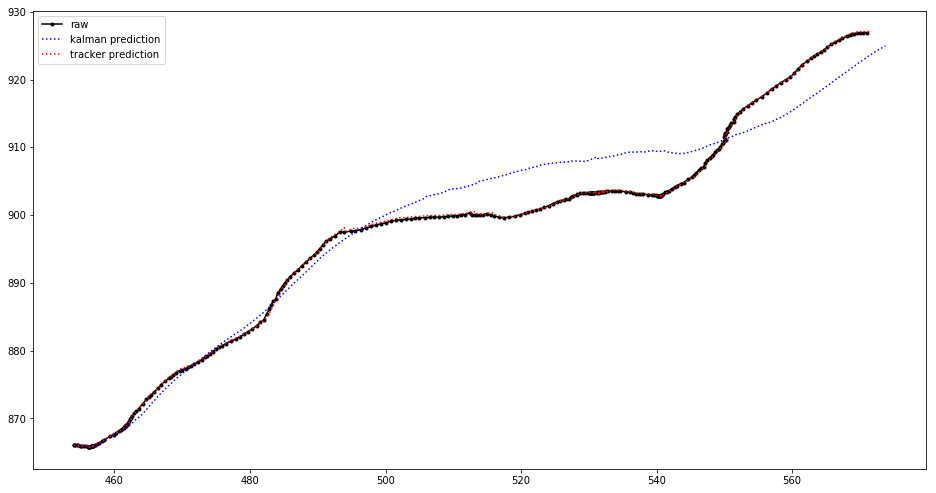

In [12]:
trk = tracks[0]


kal_mu_x = trk.kalman(1)
kal_mu_y = trk.kalman(2)
kal_pred_x = trk.kalman(13)
kal_pred_y = trk.kalman(14)

#a = agents[0]

plt.figure(figsize=(16,10))
plt.plot(trk.x,trk.y,'k.-')
# plt.plot(trk2.x,trk2.y,'k-')
plt.plot(kal_mu_x, kal_mu_y,'b:')
plt.plot(kal_pred_x, kal_pred_y,'r:')
plt.axis('image')
plt.legend(['raw', 'kalman prediction', 'tracker prediction'])
plt.show()


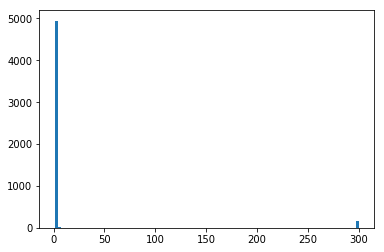

In [13]:
tl = [len(trk) for trk in tracks2]

plt.figure()
plt.hist(tl, bins=100)
plt.show()

We'll assume that the Kalman filter outputs a mean position ($\mu$) and covariance ($\Sigma$). Multivariate normal distribution where n=3:

\begin{equation}
f(x)=\frac{1}{\sqrt{(2\pi)^n|\boldsymbol\Sigma|}}
\exp\left(-\frac{1}{2}({x}-{\mu})^T{\boldsymbol\Sigma}^{-1}({x}-{\mu})
\right)
\end{equation}

In [14]:
def bivariate_PDF(mu, sigma, samples=50):
    lims = np.linspace(-1.5,1.5,samples)
    xx,yy = np.meshgrid(lims,lims)
    x = np.zeros((samples*samples,3)) # note that we'll keep z=0
    x[:,0] = np.ravel(xx)
    x[:,1] = np.ravel(yy)
    
    mu = np.asarray(mu).reshape(-1)
    sigma = np.asarray(sigma)
    
    f_x = stats.multivariate_normal.pdf(x, mean=mu, cov=sigma)
    
    return np.reshape(f_x, (samples,samples))

### inspect a tracklet

In [15]:
def inspect(trk_ID):
    trk = tracks2[trk_ID]
    dims = ['x','y','z']
    plt.figure(figsize=(16,10))
    for n, d in enumerate(dims):
        plt.subplot(3,1,n+1)
        mu = trk.kalman(n+1)
        cov = trk.kalman(4+n*3+n) # argh! complex indexing
        plt.errorbar(trk.kalman(0), mu, yerr=3.*cov, color='lightgrey')
        plt.plot(trk.kalman(0), mu, color='b')
        plt.xlabel('Time (frames)')
        plt.ylabel(r'{0:s} (Pixels $\pm \sigma_{0:s}^2$)'.format(d))
        plt.autoscale(enable=True, axis='x', tight=True)
        plt.autoscale(enable=True, axis='y', tight=True)
    plt.show()

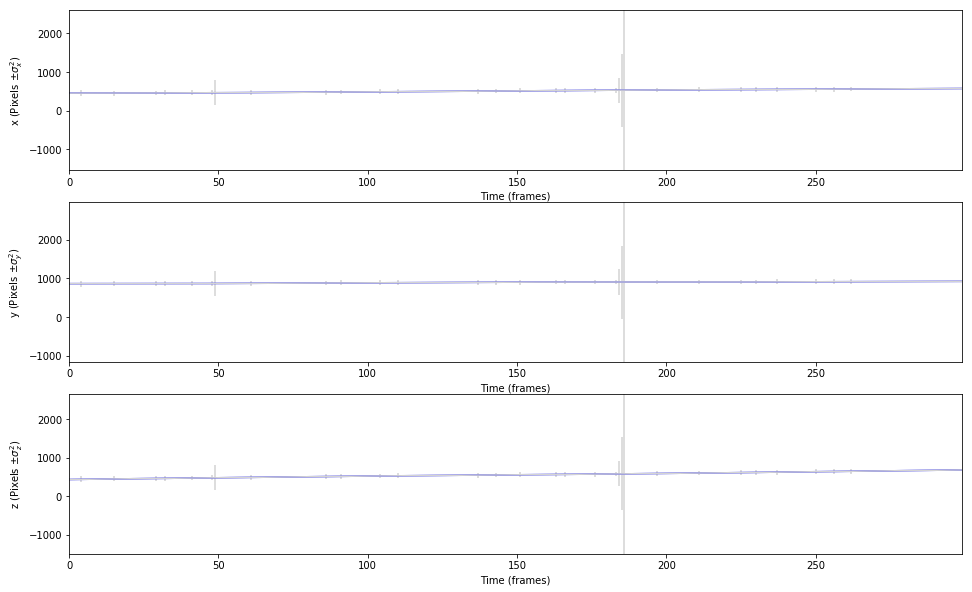

In [16]:
inspect(0)